In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import optimizers

In [3]:
train_dir = "C:/Users/keert/Downloads/project/knee_dataset/train"
validation_dir = "C:/Users/keert/Downloads/project/knee_dataset/valid"
test_dir ="C:/Users/keert/Downloads/project/knee_dataset/test"

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        batch_size=20,
        class_mode='binary')

Found 400 images belonging to 2 classes.


Found 50 images belonging to 2 classes.


# model

In [5]:
conv_base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(128, 128, 3))

In [6]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 23900449 (91.17 MB)
Trainable params: 23866017 (91.04 MB)
Non-trainable params: 34432 (134.50 KB)
_________________________________________________________________


In [9]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

In [10]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("best_model_osteoarthritis.h5", save_best_only =True)

early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    restore_best_weights=True,
    patience = 10
)

In [11]:
history = model.fit(
      train_generator,
      steps_per_epoch=13,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=2,
      callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 0.6371 - acc: 0.5923

C:\Users\keert\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 263s 10s/step - loss: 0.6371 - acc: 0.5923 - val_loss: 0.6628 - val_acc: 0.6750
Epoch 2/50
13/13 [==============================] - 113s 8s/step - loss: 0.5507 - acc: 0.7231 - val_loss: 0.7120 - val_acc: 0.6750
Epoch 3/50
13/13 [==============================] - 120s 9s/step - loss: 0.5518 - acc: 0.7308 - val_loss: 0.7842 - val_acc: 0.6000
Epoch 4/50
13/13 [==============================] - 101s 7s/step - loss: 0.5253 - acc: 0.7385 - val_loss: 0.7358 - val_acc: 0.6250
Epoch 5/50
13/13 [==============================] - 127s 10s/step - loss: 0.4690 - acc: 0.7731 - val_loss: 0.5268 - val_acc: 0.7500
Epoch 6/50
13/13 [==============================] - 97s 7s/step - loss: 0.4492 - acc: 0.7808 - val_loss: 0.7676 - val_acc: 0.6750
Epoch 7/50
13/13 [==============================] - 113s 9s/step - loss: 0.3947 - acc: 0.8038 - val_loss: 0.7289 - val_acc: 0.7000
Epoch 8/50
13/13 [==============================] - 22s 1s/step - loss: 0.3853 - acc: 0.8654 

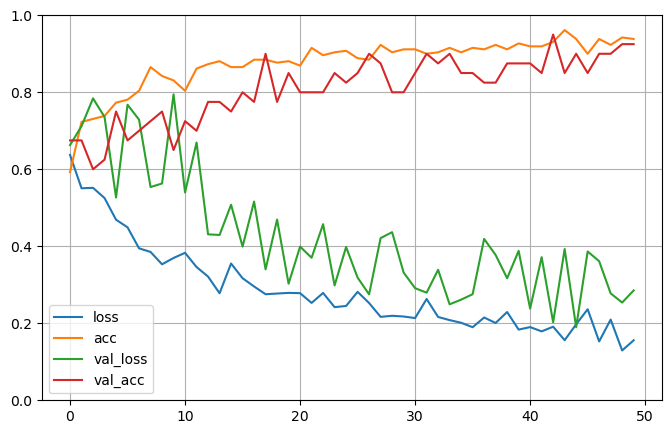

In [12]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# probablistic feature extraction

# SVM 

In [29]:
# Extract features from the trained CNN model
train_features = model.predict(train_generator)
validation_features = model.predict(validation_generator)

# Flatten the features to be compatible with SVM classifier
train_features_flatten = train_features.reshape(train_features.shape[0], -1)
validation_features_flatten = validation_features.reshape(validation_features.shape[0], -1)

# Initialize SVM classifier
svm_classifier = SVC(
    kernel='linear', 
    degree=3, 
    C=1.0, 
    tol=1e-3, 
    cache_size=200
)

# Train SVM classifier using the extracted features
svm_classifier.fit(train_features_flatten, train_generator.classes)

# Evaluate SVM classifier on validation data
validation_predictions = svm_classifier.predict(validation_features_flatten)
validation_accuracy = accuracy_score(validation_generator.classes, validation_predictions)
print("SVM Classifier Validation Accuracy:", validation_accuracy)

3/3 [==============================] - 1s 149ms/step
SVM Classifier Validation Accuracy: 0.94


# KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize KN classifier with specified hyperparameters
knn_classifier = KNeighborsClassifier(
    n_neighbors=5, 
    weights='uniform', 
    leaf_size=30, 
    metric='minkowski'
)

# Train KN classifier using the extracted features
knn_classifier.fit(train_features_flatten, train_generator.classes)

# Evaluate KN classifier on validation data
validation_predictions_knn = knn_classifier.predict(validation_features_flatten)
validation_accuracy_knn = accuracy_score(validation_generator.classes, validation_predictions_knn)
print("K-Neighbors Classifier Validation Accuracy:", validation_accuracy_knn)


3/3 [==============================] - 1s 160ms/step
K-Neighbors Classifier Validation Accuracy: 0.91


# RF

In [34]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest classifier with specified hyperparameters
rf_classifier = RandomForestClassifier(
    max_depth=300, 
    n_estimators=300, 
    criterion="gini",  # Corrected typo in crimterion parameter
    max_features="sqrt", 
    random_state=42  # You can set the random_state for reproducibility
)

# Train Random Forest classifier using the extracted features
rf_classifier.fit(train_features_flatten, train_generator.classes)

# Evaluate Random Forest classifier on validation data
validation_predictions_rf = rf_classifier.predict(validation_features_flatten)
validation_accuracy_rf = accuracy_score(validation_generator.classes, validation_predictions_rf)
print("Random Forest Classifier Validation Accuracy:", validation_accuracy_rf)


3/3 [==============================] - 3s 238ms/step
Random Forest Classifier Validation Accuracy: 0.90


# SGD

In [35]:
from sklearn.linear_model import SGDClassifier

# Initialize SGD classifier with specified hyperparameters
sgd_classifier = SGDClassifier(
    max_iter=1000, 
    tol=1e-3, 
    loss='hinge', 
    penalty='l2',  
    random_state=42  
)

# Train SGD classifier using the extracted features
sgd_classifier.fit(train_features_flatten, train_generator.classes)

# Evaluate SGD classifier on validation data
validation_predictions_sgd = sgd_classifier.predict(validation_features_flatten)
validation_accuracy_sgd = accuracy_score(validation_generator.classes, validation_predictions_sgd)
print("SGD Classifier Validation Accuracy:", validation_accuracy_sgd)


3/3 [==============================] - 2s 581ms/step
SGD Classifier Validation Accuracy: 0.92


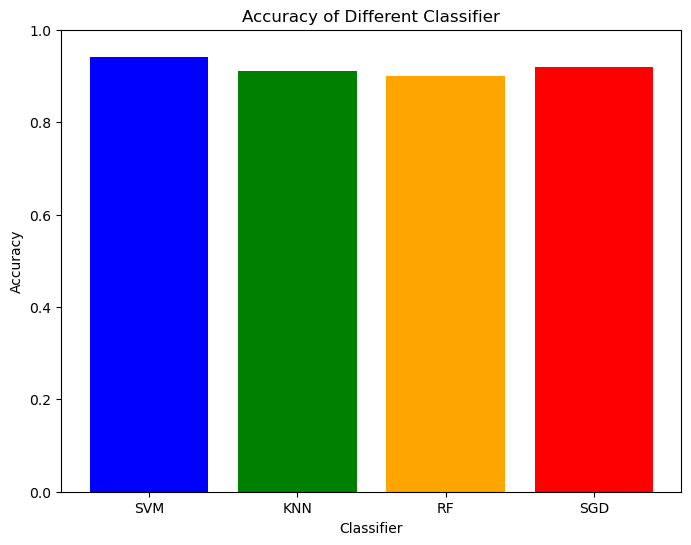

In [4]:
import matplotlib.pyplot as plt

# List of classifier names
classifier = ['SVM', 'KN', 'RF', 'SGD']

# Corresponding validation accuracies
accuracy = [validation_accuracy_rf, validation_accuracy_svm, validation_accuracy_knn, validation_accuracy_sgd]

# Create bar chart
plt.figure(figsize=(8, 6))
plt.bar(classifier, accuracy, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Classifier')
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1 for accuracy values
plt.show()


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# True labels for the validation data
true_labels = validation_generator.classes

# SVM classifier
svm_accuracy = accuracy_score(true_labels, validation_predictions_svm)
svm_precision = precision_score(true_labels, validation_predictions_svm)
svm_recall = recall_score(true_labels, validation_predictions_svm)
svm_f1_score = f1_score(true_labels, validation_predictions_svm)

print("\nSVM Classifier Metrics:")
print("Accuracy:", svm_accuracy)
print("Precision:", svm_precision)
print("Recall:", svm_recall)
print("F1 Score:", svm_f1_score)

# K-Neighbors classifier
knn_accuracy = accuracy_score(true_labels, validation_predictions_knn)
knn_precision = precision_score(true_labels, validation_predictions_knn)
knn_recall = recall_score(true_labels, validation_predictions_knn)
knn_f1_score = f1_score(true_labels, validation_predictions_knn)

print("\nK-Neighbors Classifier Metrics:")
print("Accuracy:", knn_accuracy)
print("Precision:", knn_precision)
print("Recall:", knn_recall)
print("F1 Score:", knn_f1_score)

# Random Forest classifier
rf_accuracy = accuracy_score(true_labels, validation_predictions_rf)
rf_precision = precision_score(true_labels, validation_predictions_rf)
rf_recall = recall_score(true_labels, validation_predictions_rf)
rf_f1_score = f1_score(true_labels, validation_predictions_rf)

print("\nRandom Forest Classifier Metrics:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1_score)

# SGD classifier
sgd_accuracy = accuracy_score(true_labels, validation_predictions_sgd)
sgd_precision = precision_score(true_labels, validation_predictions_sgd)
sgd_recall = recall_score(true_labels, validation_predictions_sgd)
sgd_f1_score = f1_score(true_labels, validation_predictions_sgd)

print("\nSGD Classifier Metrics:")
print("Accuracy:", sgd_accuracy)
print("Precision:", sgd_precision)
print("Recall:", sgd_recall)
print("F1 Score:", sgd_f1_score)


SVM Classifier Metrics:
Accuracy: 0.94
Precision: 0.91
Recall: 0.93
F1 Score: 0.91

K-Neighbors Classifier Metrics:
Accuracy: 0.91
Precision: 0.90
Recall: 0.90
F1 Score: 0.90

Random Forest Classifier Metrics:
Accuracy: 0.90
Precision: 0.90
Recall: 0.90
F1 Score: 0.90

SGD Classifier Metrics:
Accuracy: 0.92
Precision: 0.91
Recall: 0.90
F1 Score: 0.90


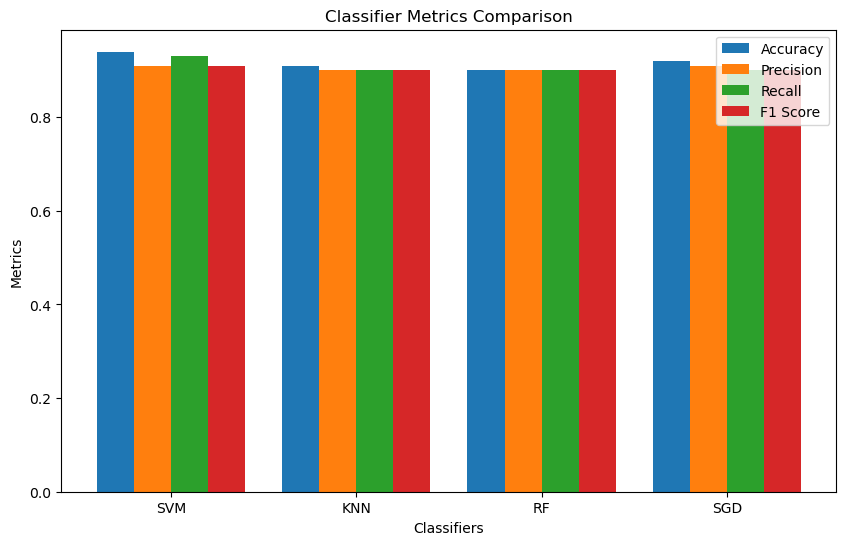

In [2]:
import matplotlib.pyplot as plt

# Classifier names
classifiers = ['SVM', 'KNN', 'RF', 'SGD']

# Metrics values
accuracy = [svm_accuracy, knn_accuracy, rf_accuracy, sgd_accuracy]
precision = [svm_precision, knn_precision, rf_precision, sgd_precision]
recall = [svm_recall, knn_recall, rf_recall, sgd_recall]
f1_score = [svm_f1_score, knn_f1_score, rf_f1_score, sgd_f1_score]

x = range(len(classifiers))

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(x, accuracy, width=0.2, label='Accuracy')
plt.bar([p + 0.2 for p in x], precision, width=0.2, label='Precision')
plt.bar([p + 0.4 for p in x], recall, width=0.2, label='Recall')
plt.bar([p + 0.6 for p in x], f1_score, width=0.2, label='F1 Score')

plt.xlabel('Classifiers')
plt.ylabel('Metrics')
plt.title('Classifier Metrics Comparison')
plt.xticks([p + 0.3 for p in x], classifiers)
plt.legend()
plt.show()
